# Adaptive PDE discretizations on Cartesian grids
## Volume : Reproducible research
## Part : Convergence rates
## Chapter : Eikonal equations

In this notebook, we check the convergence rate of the Eikonal equation solver, when schemes of various orders are applied in conjunction with appropriate source factorization.

The test cases are taken from the notebook on achieving [high accuracy](../Notebooks_FMM/HighAccuracy.ipynb). Let us acknowledge, however, that in several instances the parameter dictating the strengh of the anisotropy is tuned lower. This is needed to illustrate the third order accuracy, which otherwise would (likely) only be visible at very large resolutions.

A more in depth discussion of the accuracy achievable using Eulerian schemes is presented in the notebook [EikonalEulerian_Rate](EikonalEulerian_Rate.ipynb).

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Test configuration](#1.-Test-configuration)
  * [2. Isotropic metrics](#2.-Isotropic-metrics)
    * [2.1 Eulerian scheme](#2.1-Eulerian-scheme)
    * [2.2 Semi-Lagrangian scheme](#2.2-Semi-Lagrangian-scheme)
  * [3. Riemannian metrics](#3.-Riemannian-metrics)
    * [3.1 Eulerian scheme](#3.1-Eulerian-scheme)
    * [3.2 Semi-Lagrangian scheme](#3.2-Semi-Lagrangian-scheme)
  * [4. Rander metrics](#4.-Rander-metrics)
  * [5. Metrics defined by a Hooke tensor](#5.-Metrics-defined-by-a-Hooke-tensor)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('EikonalRate','Repro'))

In [2]:
from agd import Metrics
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd.AutomaticDifferentiation.Optimization import norm

In [3]:
from agd.ExportedCode.Notebooks_FMM import HighAccuracy

In [4]:
import numpy as np
from matplotlib import pyplot as plt

### 0.1 Additional configuration

**Notebook incompatible with the GPU solver.**
High accuracy fast marching methods are only implemented for the CPU eikonal solver, and not for the GPU eikonal solver. 
Indeed, the sequential nature of the fast-marching scheme allows for an easier implementation of high order schemes, in the *recomputation* step right before the value is *freezed*. For the GPU parallel eikonal solver, there is no obvious place to safely insert the high order scheme, and a naive use leads to scheme instability.


In [5]:
#raise ad.DeliberateNotebookError("High order schemes are not implemented on the GPU")

**Large instances.** 
Enable this option to use large problem instances. Computation time may get a little longer.

In [6]:
large_instances = False

## 1. Test configuration

In [7]:
max_res = 2000 if large_instances else 500
n_res = 16 if large_instances else 12
resolutions = np.array([2*int(np.exp(k))+1 for k in np.linspace(1.5,np.log(max_res/2),n_res)])

In [8]:
print(f"Resolutions n x n used in the numerical tests : n = {resolutions} .")

Resolutions n x n used in the numerical tests : n = [  9  13  19  27  39  55  81 115 167 241 347 499] .


We use schemes of various orders, improved by the HAFMM (high accuracy fast marching method) technique of Sethian, and two types of source factorization.

In [9]:
schemes = [
    ({}, "First order, no factorization", 1),
    ({'factoringRadius':-1}, "First order, simple factorization", 1),  
    ({'factoringRadius':-1, 'order':2}, "Second order, simple factorization", 2),
    ({'factoringRadius':-1, 'factoringPointChoice':'Both', 'order':2}, "Second order, accurate factorization", 2),
    ({'factoringRadius':-1, 'order':3}, "Third order, simple factorization", 3),
    ({'factoringRadius':-1, 'factoringPointChoice':'Both', 'order':3}, "Third order, accurate factorization", 3),
]

## 2. Isotropic metrics

### 2.1 Eulerian scheme

We use here the standard Eulerian finite differences discretization (Rouy et al) of the isotropic eikonal equation. 
Empirical remarks on the convergence order:
* **The first order scheme alone does not achieve first order convergence. A source factorization is needed for that purpose.
* The second order scheme, combined with the simple source factorization, achieves second order convergence.
* The accurate factorization improves the results, by a constant factor. 
* Third order convergence is not achieved.

In [10]:
def PoincareTest(n,update=tuple()):
    """
    Checks the accuracy of isotropic fast marching on a Poincare model of the hyperpolic plane.
    """
    # Setup the model
    hfmIn = Eikonal.dictIn({
        'model':'Isotropic2',
        'seed': [0.,1.5],
        'exportValues':1.,
        'verbosity':0,
    })
    hfmIn.SetRect(sides=[[-0.5,0.5],[1,2]],dimx=n,sampleBoundary=True)
    X = hfmIn.Grid()
    hfmIn['metric'] = Metrics.Isotropic(HighAccuracy.PoincareCost(X))
    hfmIn.update(update)
    
    # Run, and compute the exact solution
    hfmOut = hfmIn.Run()
    approx = hfmOut['values']
    exact = HighAccuracy.PoincareDistance(hfmIn['seed'],X)
    
    # Output
    result = [norm(approx-exact,ord=p,averaged=True) for p in (1,2,np.inf)] # L1, L2, LInf errors
    result.append(hfmOut['FMCPUTime'])
    return result

In [11]:
results = np.array([[PoincareTest(n,update=scheme[0]) for n in resolutions] for scheme in schemes])

/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:27: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1))
/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Dense.py:141: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef)


/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/Metrics/isotropic.py:41: RuntimeWarning: invalid value encountered in divide
  return self.cost*v/ad.Optimization.norm(v,ord=2,axis=0)


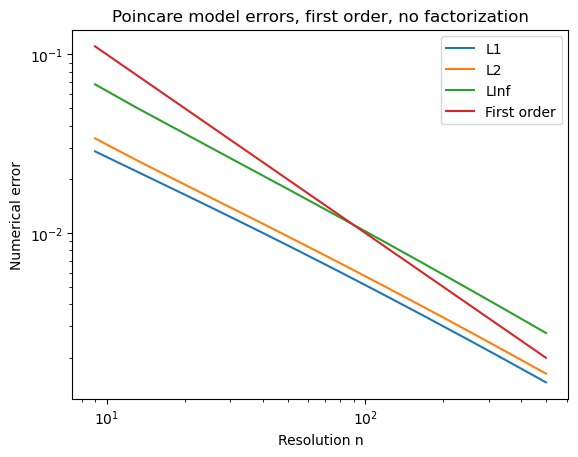

In [12]:
plt.title("Poincare model errors, first order, no factorization")
plt.loglog(resolutions,results[0,:,:-1],resolutions,1/resolutions);
plt.xlabel('Resolution n'); plt.ylabel('Numerical error')
plt.legend(("L1","L2","LInf","First order"));

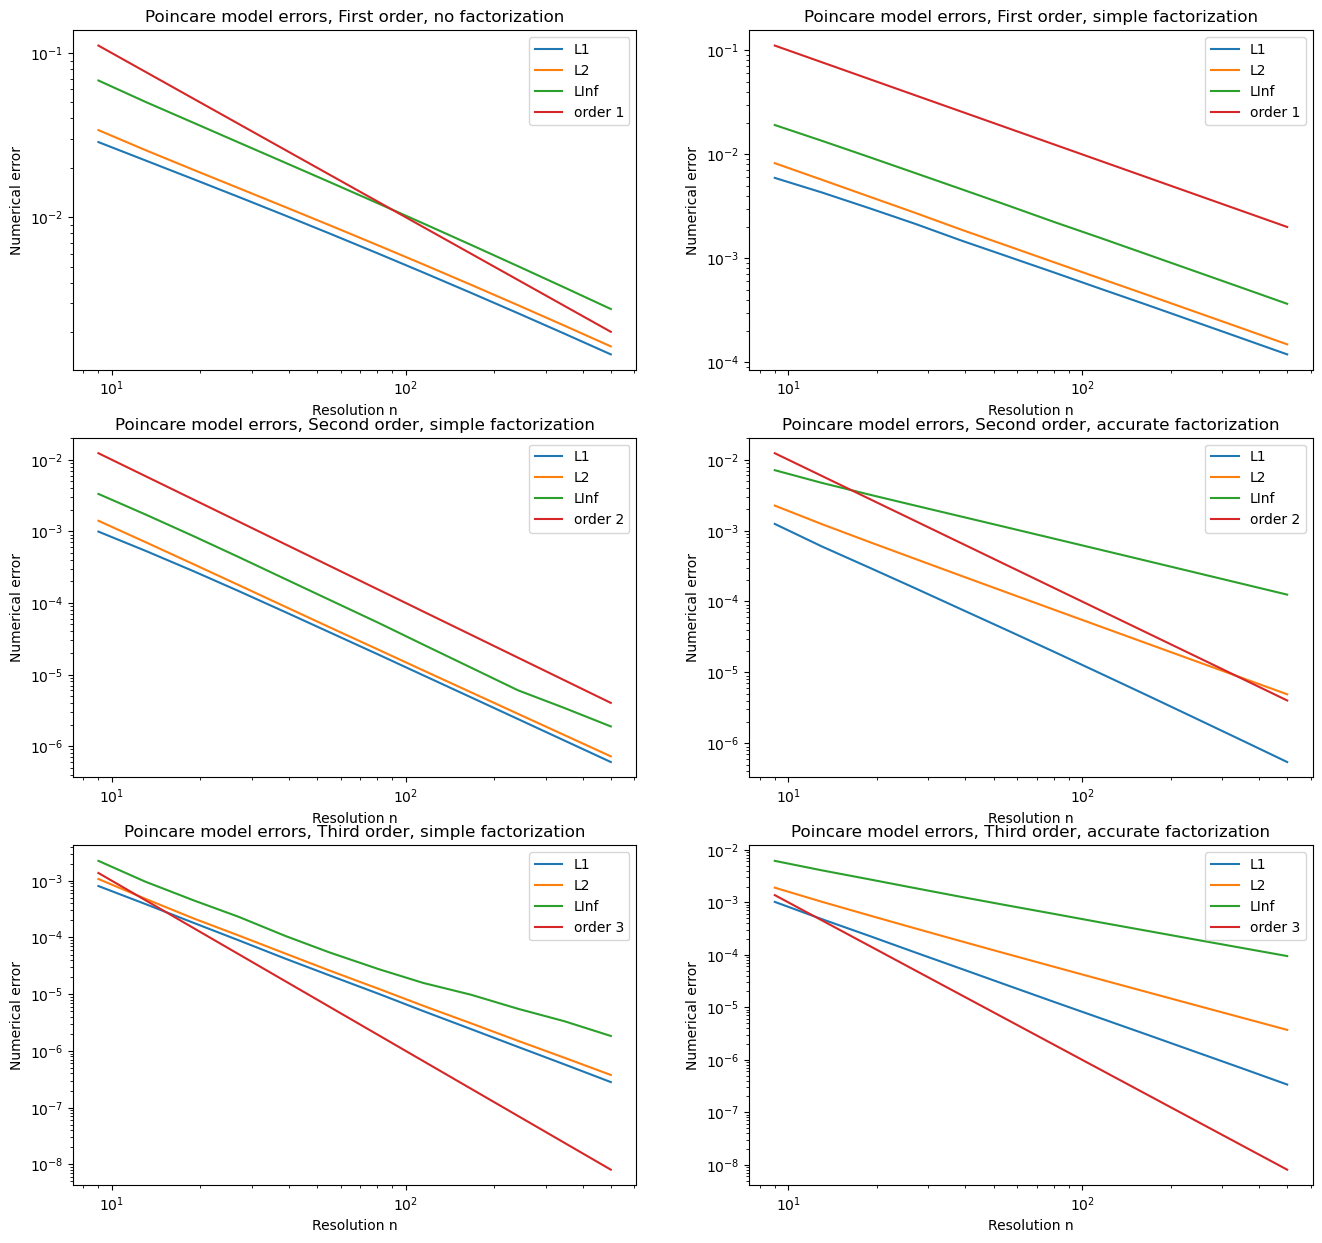

In [13]:
plt.figure(figsize=[16,15])
for i,(scheme,result) in enumerate(zip(schemes,results)):
    plt.subplot(3,2,1+i)
    plt.title("Poincare model errors, "+scheme[1])
    plt.loglog(resolutions, result[:,:-1], resolutions, 1/resolutions**scheme[2])
    plt.xlabel("Resolution n"); plt.ylabel("Numerical error")
    plt.legend(("L1","L2","LInf",f"order {scheme[2]}"))

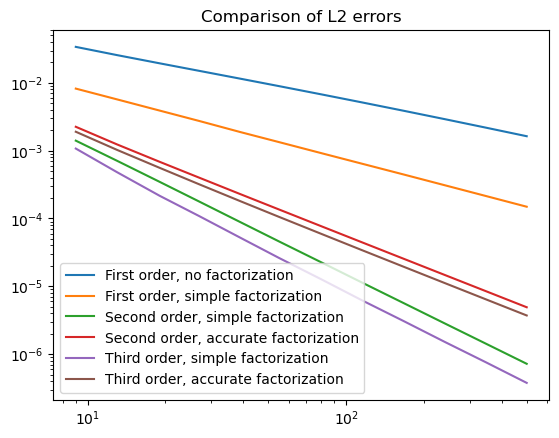

In [14]:
plt.title("Comparison of L2 errors")
plt.loglog(resolutions, results[:,:,1].T); #, resolutions, np.stack([1/resolutions**s for s in [1,2,3]], axis=-1))
plt.legend([s[1] for s in schemes]);

### 2.2 Semi-Lagrangian scheme

We use a semi-Lagrangian scheme, designed for Rander metrics - a generalization of Riemannian metrics - but which is also able to deal with isotropic metrics as a special case. Remarks on accuracy : 
* The semi-Lagrangian scheme is not much more accurate than the usual Eulerian scheme, when using first and second order finite differences.
* The semi-Lagrangian scheme is able to reach third order accuracy, with the adequate source factorization and third order finite differences, in contrast with the Eulerian scheme.
* The simple source factorization is insufficient to reach third order accuracy.

In [15]:
results = np.array([[PoincareTest(n,update={'model':'Rander2',**scheme[0]}) 
                     for n in resolutions] for scheme in schemes])

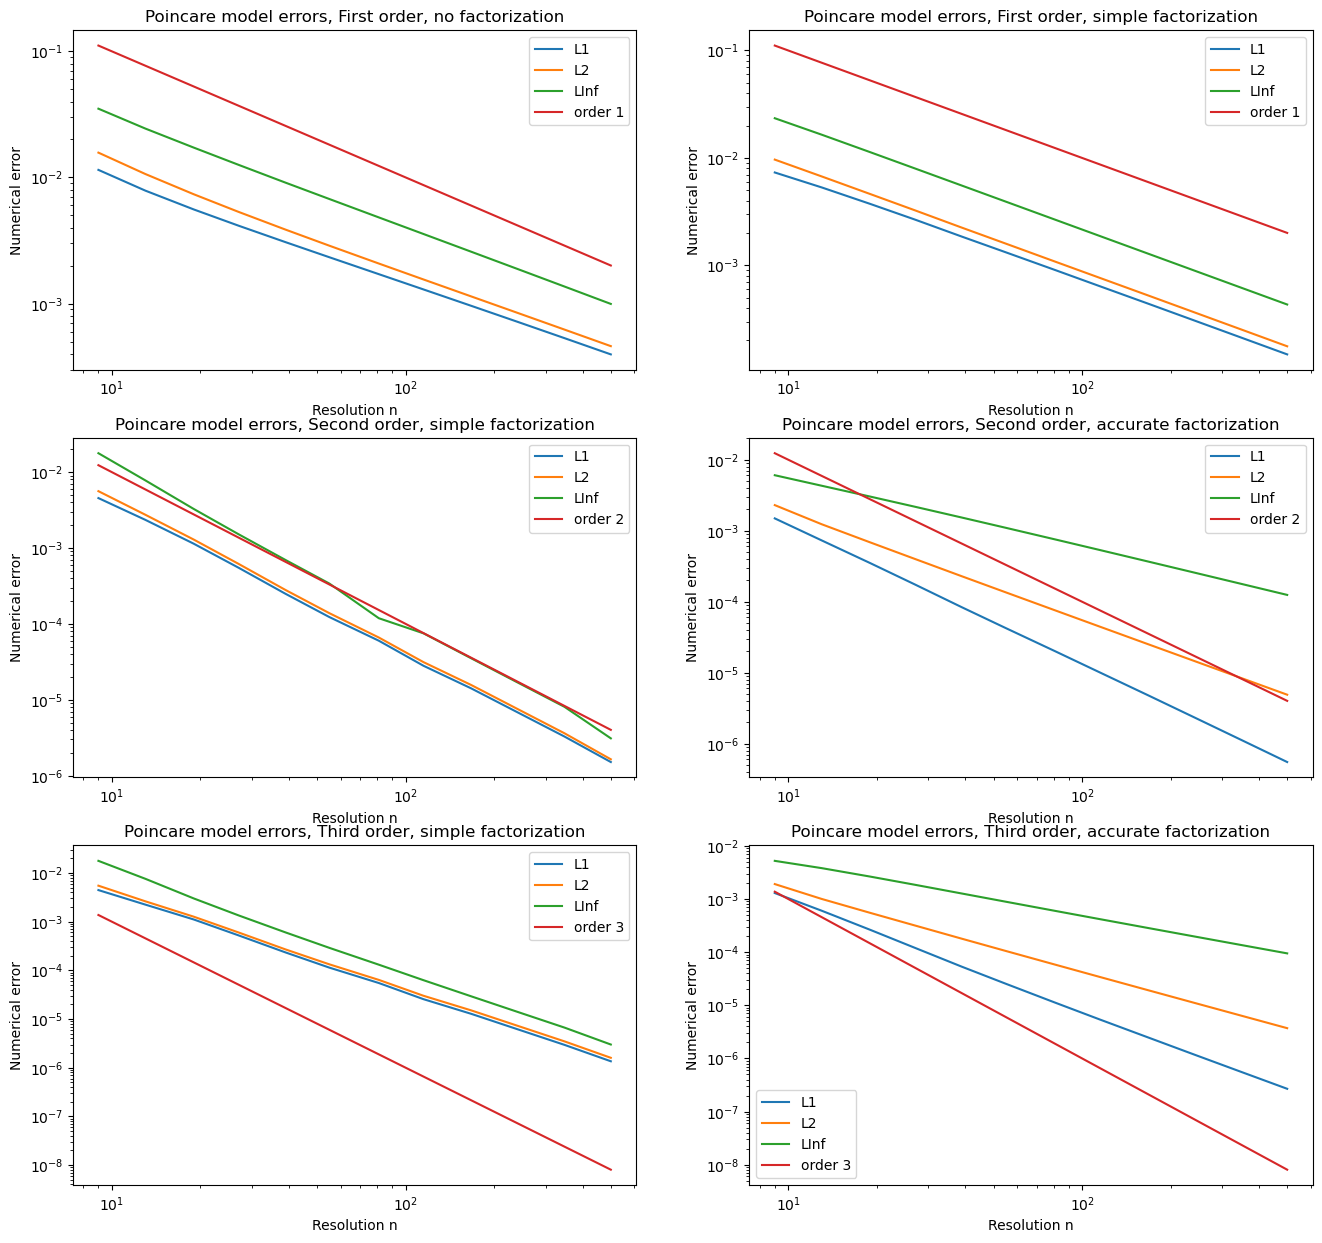

In [16]:
plt.figure(figsize=[16,15])
for i,(scheme,result) in enumerate(zip(schemes,results)):
    plt.subplot(3,2,1+i)
    plt.title("Poincare model errors, "+scheme[1])
    plt.loglog(resolutions, result[:,:-1], resolutions, 1/resolutions**scheme[2])
    plt.xlabel("Resolution n"); plt.ylabel("Numerical error")
    plt.legend(("L1","L2","LInf",f"order {scheme[2]}"))

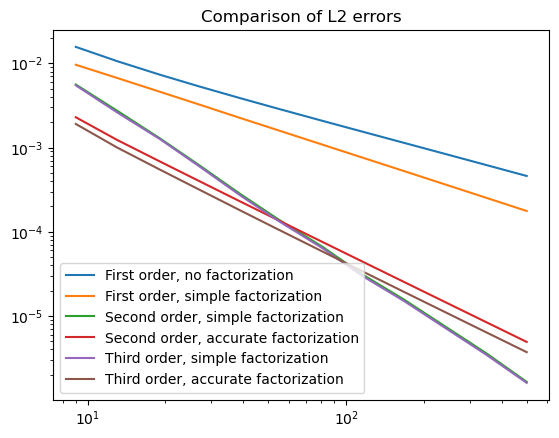

In [17]:
plt.title("Comparison of L2 errors")
plt.loglog(resolutions, results[:,:,1].T); #, resolutions, np.stack([1/resolutions**s for s in [1,2,3]], axis=-1))
plt.legend([s[1] for s in schemes]);

## 3. Riemannian metrics

We again another example from the notebook HighAccuracy, where a Riemannian metric is obtained by applying a change of variables to a constant metric.

### 3.1 Eulerian scheme

Empirical remarks on the observed convergence rates:
* Quite strangely, the convergence rate seems to be close to 1 even without source factorization - expectation is $O(\log(n)/n)$. This could be due to the fact that the problem is much harder - the metric is strongly anisotropic, and has strong variations over the domain - hence the inaccuracy due to the source plays a more minor role.
* Third order accuracy is not achieved with an Eulerian scheme, similarly to isotropic metrics. This is expected.

In [18]:
def RiemannTest(n,update=tuple()):
    """
    Checks the accuracy of isotropic fast marching on a Poincare model of the hyperpolic plane.
    """
    # Setup the model
    hfmIn = Eikonal.dictIn({
        'model':'Riemann2',
        'seed': [0.,0.],
        'exportValues':1.,
        'verbosity':0,
    })
    hfmIn.SetRect(sides=[[-1,1],[-0.5,0.5]],dimx=n)
    X = hfmIn.Grid()
    
    from agd.ExportedCode.Notebooks_FMM.HighAccuracy import RiemannMetric, RiemannExact, diagCoef
    def diff(x,y): return HighAccuracy.diff(x,y,0.3) # Slightly less distortion than original (α=0.5)
    hfmIn['metric'] = RiemannMetric(diagCoef,diff,*X)
    hfmIn.update(update)
    
    # Run, and compute the exact solution
    hfmOut = hfmIn.Run()
    approx = hfmOut['values']
    exact = RiemannExact(diagCoef,diff,*X)
    shadow = np.abs(X[0]-X[1])>=0.5
#    plt.contourf(*X,approx); plt.axis('equal')
    
    # Output
    result = [norm(np.where(shadow,0,approx-exact),ord=p,averaged=True) for p in (1,2,np.inf)] # L1, L2, LInf errors
    result.append(hfmOut['FMCPUTime'])
    return result

In [19]:
RiemannTest(11,update={'factoringRadius':-1})

[0.027233826693198026, 0.049294500890697986, 0.12050846910010904, 2.3e-05]

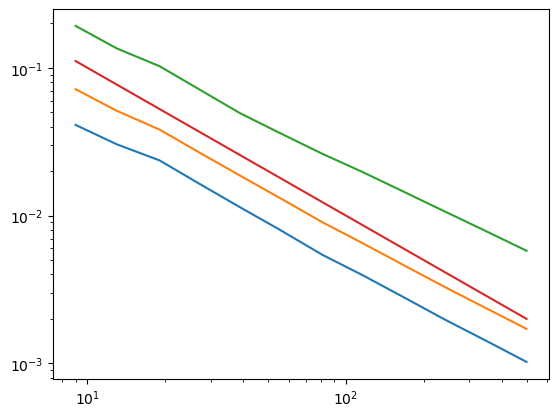

In [20]:
result = np.array([RiemannTest(n,update=schemes[0][0]) for n in resolutions])
plt.loglog(resolutions, result[:,:-1],resolutions,1/resolutions);

In [21]:
results = np.array([[RiemannTest(n,update=scheme[0]) for n in resolutions] for scheme in schemes])

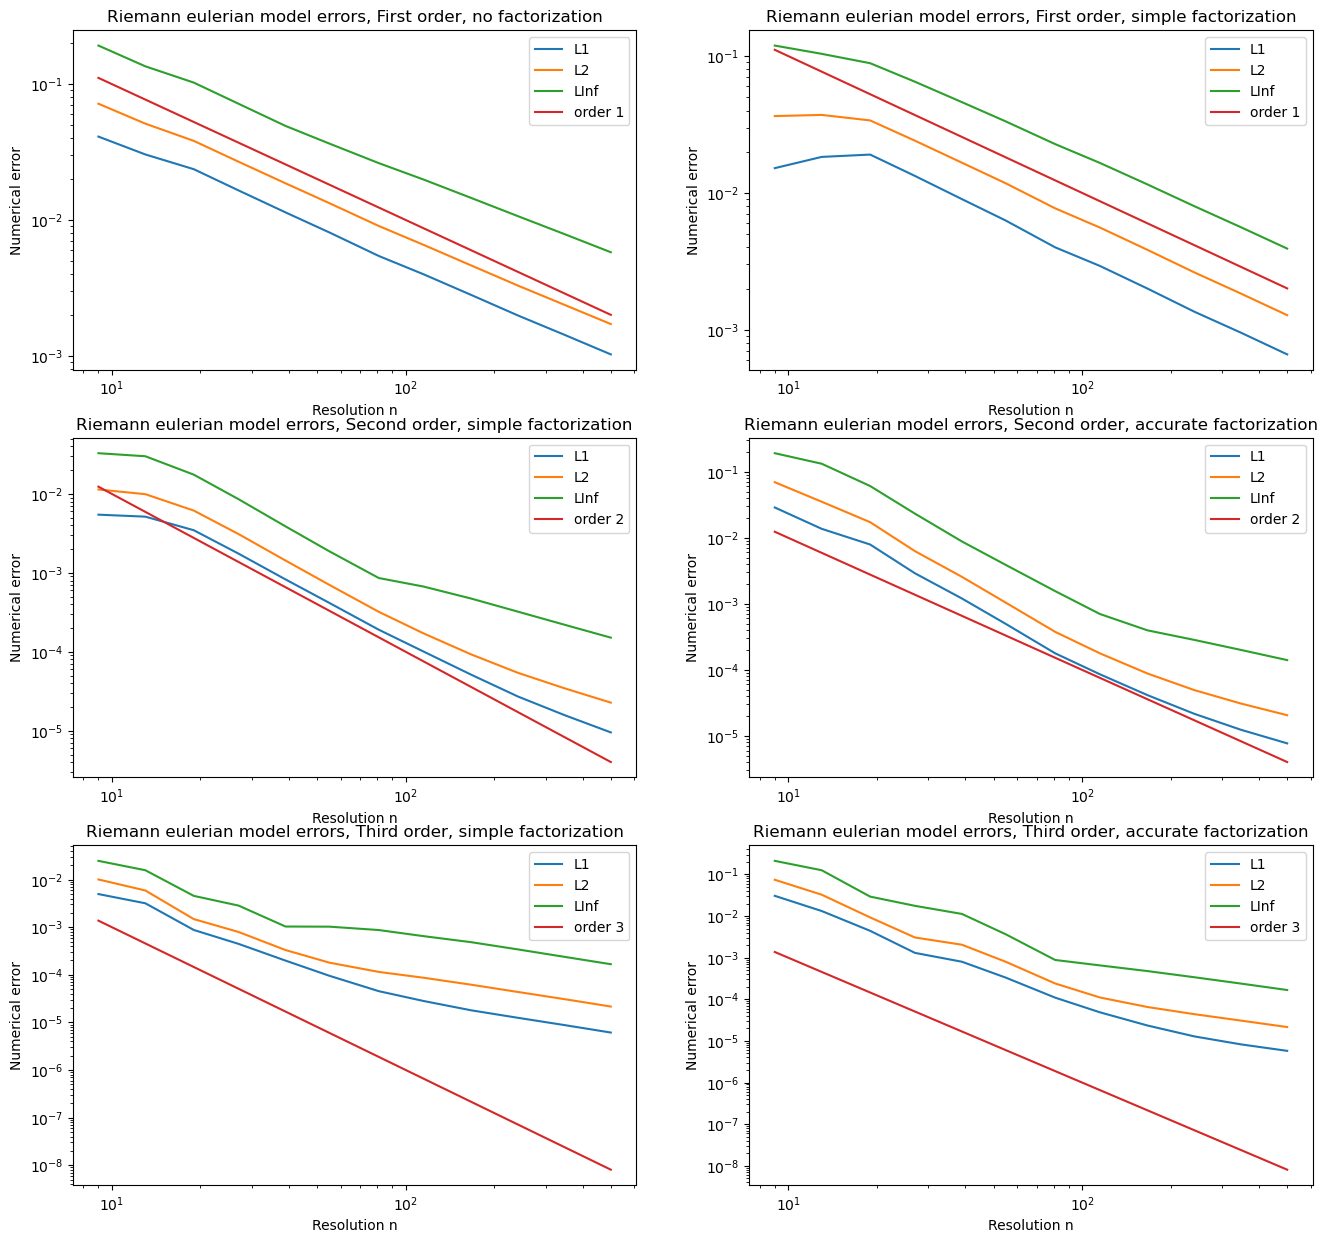

In [22]:
plt.figure(figsize=[16,15])
for i,(scheme,result) in enumerate(zip(schemes,results)):
    plt.subplot(3,2,1+i)
    plt.title("Riemann eulerian model errors, "+scheme[1])
    plt.loglog(resolutions, result[:,:-1], resolutions, 1/resolutions**scheme[2])
    plt.xlabel("Resolution n"); plt.ylabel("Numerical error")
    plt.legend(("L1","L2","LInf",f"order {scheme[2]}"))

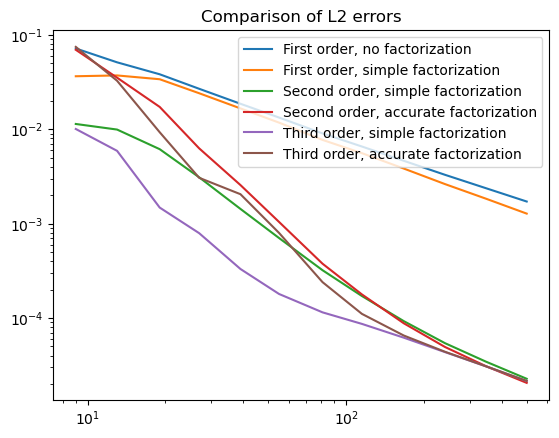

In [23]:
plt.title("Comparison of L2 errors")
plt.loglog(resolutions, results[:,:,1].T); #, resolutions, np.stack([1/resolutions**s for s in [1,2,3]], axis=-1))
plt.legend([s[1] for s in schemes]);

### 3.2 Semi-Lagrangian scheme

We the numerical results call for the following remarks.
* The *accurate* source factorization does not bring any improvements in this test case.
* The semi-Lagrangian scheme does achieve third order accuracy, contrary to the Eulerian scheme, with both types of source factorization. 
* The semi-Lagrangian scheme is less accurate than the Eulerian scheme at low resolutions with the high order schemes.  This is due, presumably, to the use of wider stencils in the PDE discretization, which are made even wider by the use of high order finite differences.

In [24]:
results = np.array([[RiemannTest(n,update={'model':'Rander2',**scheme[0]}) 
                     for n in resolutions] for scheme in schemes])

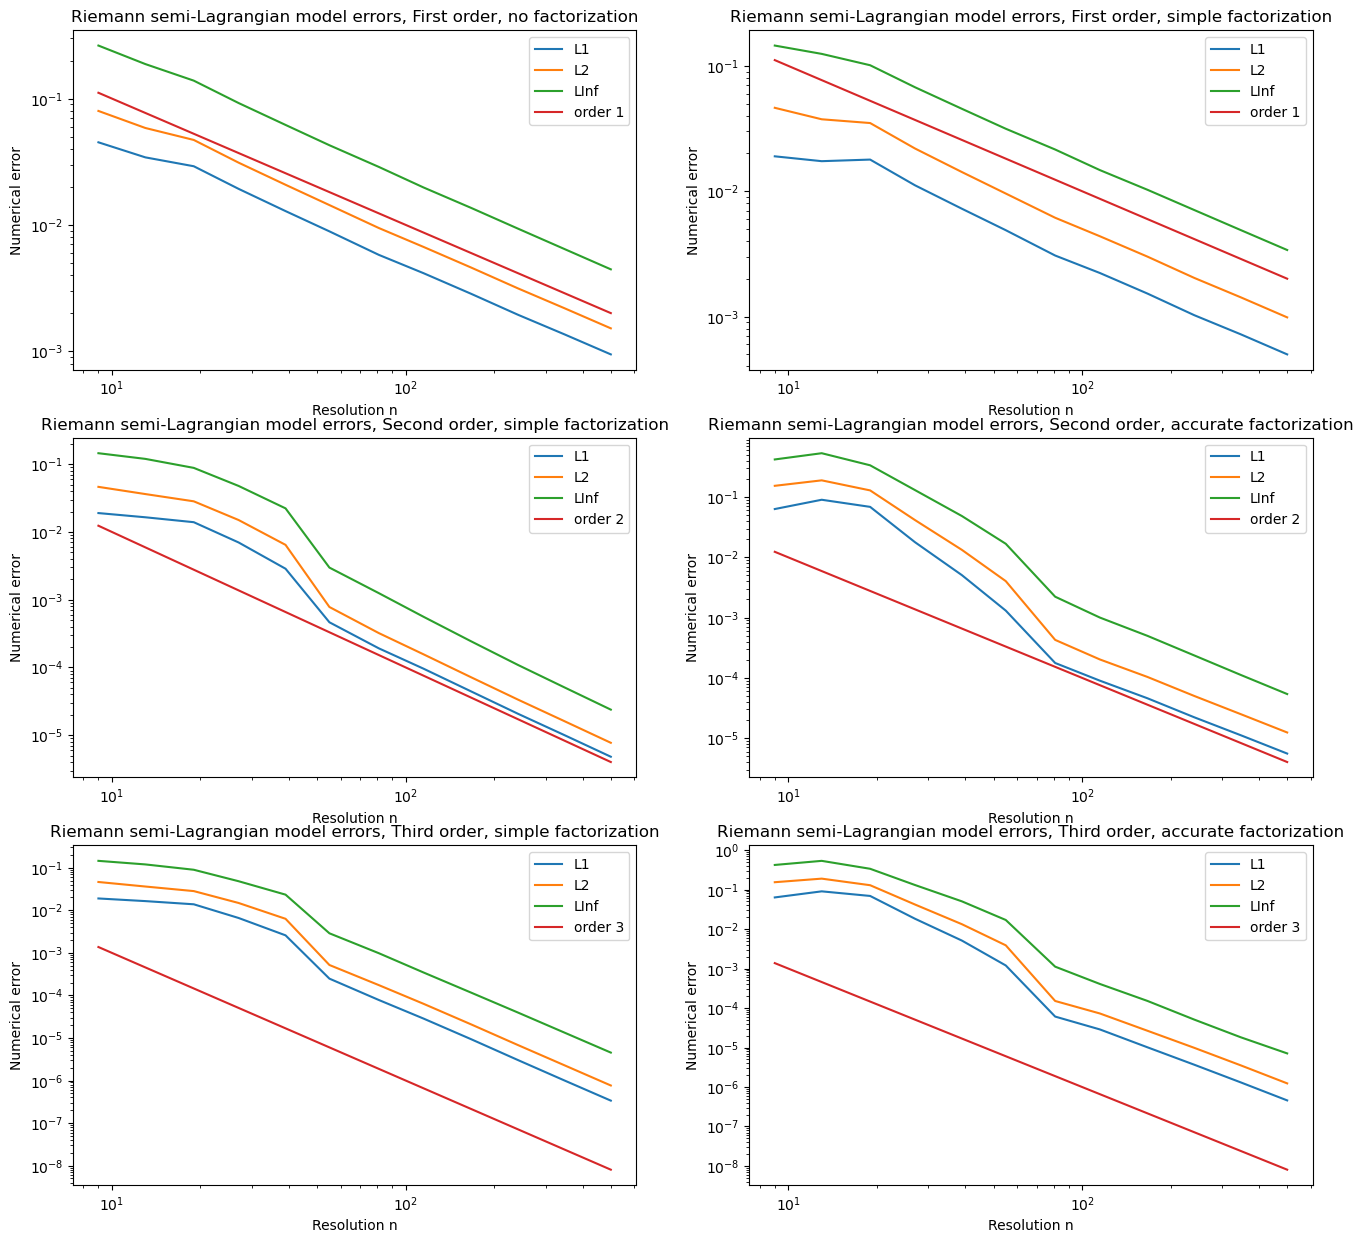

In [25]:
plt.figure(figsize=[16,15])
for i,(scheme,result) in enumerate(zip(schemes,results)):
    plt.subplot(3,2,1+i)
    plt.title("Riemann semi-Lagrangian model errors, "+scheme[1])
    plt.loglog(resolutions, result[:,:-1], resolutions, 1/resolutions**scheme[2])
    plt.xlabel("Resolution n"); plt.ylabel("Numerical error")
    plt.legend(("L1","L2","LInf",f"order {scheme[2]}"))

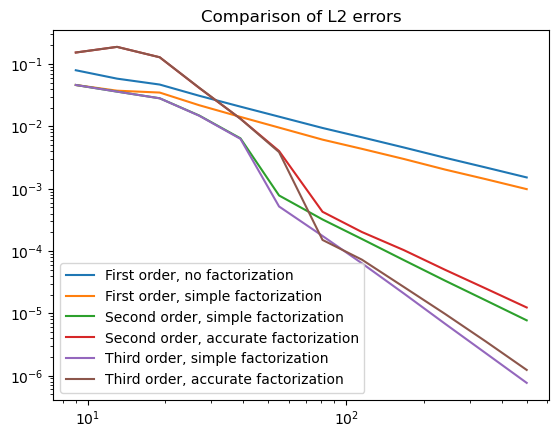

In [26]:
plt.title("Comparison of L2 errors")
plt.loglog(resolutions, results[:,:,1].T); #, resolutions, np.stack([1/resolutions**s for s in [1,2,3]], axis=-1))
plt.legend([s[1] for s in schemes]);

## 4. Rander metrics

This example involves Rander metrics, a generalisation of Riemannian metrics. The only available scheme in the CPU based HFM library is semi-Lagrangian. Note that the GPU eikonal solver uses a different scheme, which is Eulerian, but not causal (an iterative solver is needed).

In [27]:
def RanderTest(n,update=tuple()):
    """
    Checks the accuracy of isotropic fast marching on a Poincare model of the hyperpolic plane.
    """
    # Setup the model
    hfmIn = Eikonal.dictIn({
        'model':'Rander2',
        'seed': [0.,0.],
        'exportValues':1.,
        'verbosity':0,
    })
    hfmIn.SetRect(sides=[[-2,2],[-2,2]],dimx=n)
    X = hfmIn.Grid()
    γ=0.4 # Use less pronounced anisotropy, otherwise high order schemes require very large resolution 
    hfmIn['metric'] = HighAccuracy.RanderMetric(*X,γ)
    hfmIn.update(update)
    
    # Run, and compute the exact solution
    hfmOut = hfmIn.Run()
    approx = hfmOut['values']
    exact = HighAccuracy.RanderSolution(*X,γ)
    shadow = norm(X,ord=np.inf,axis=0)>=1.8
#    plt.contourf(*X,approx); plt.axis('equal')
    
    # Output
    result = [norm(np.where(shadow,0,approx-exact),ord=p,averaged=True) for p in (1,2,np.inf)] # L1, L2, LInf errors
    result.append(hfmOut['FMCPUTime'])
    return result

In [28]:
RanderTest(11)

[0.03483516200122766, 0.06115635671248596, 0.19784461702904887, 6.2e-05]

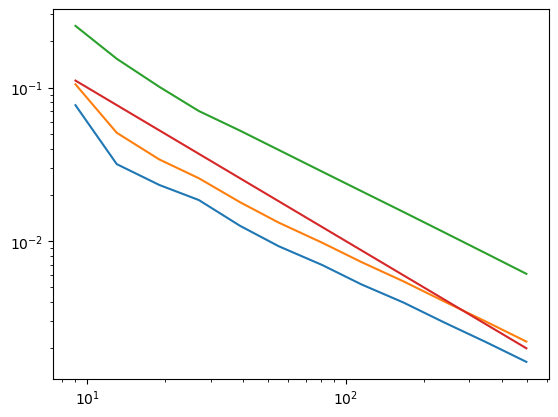

In [29]:
result = np.array([RanderTest(n,update=schemes[0][0]) for n in resolutions])
plt.loglog(resolutions, result[:,:-1],resolutions,1/resolutions);

In [30]:
results = np.array([[RanderTest(n,update=scheme[0]) for n in resolutions] for scheme in schemes])

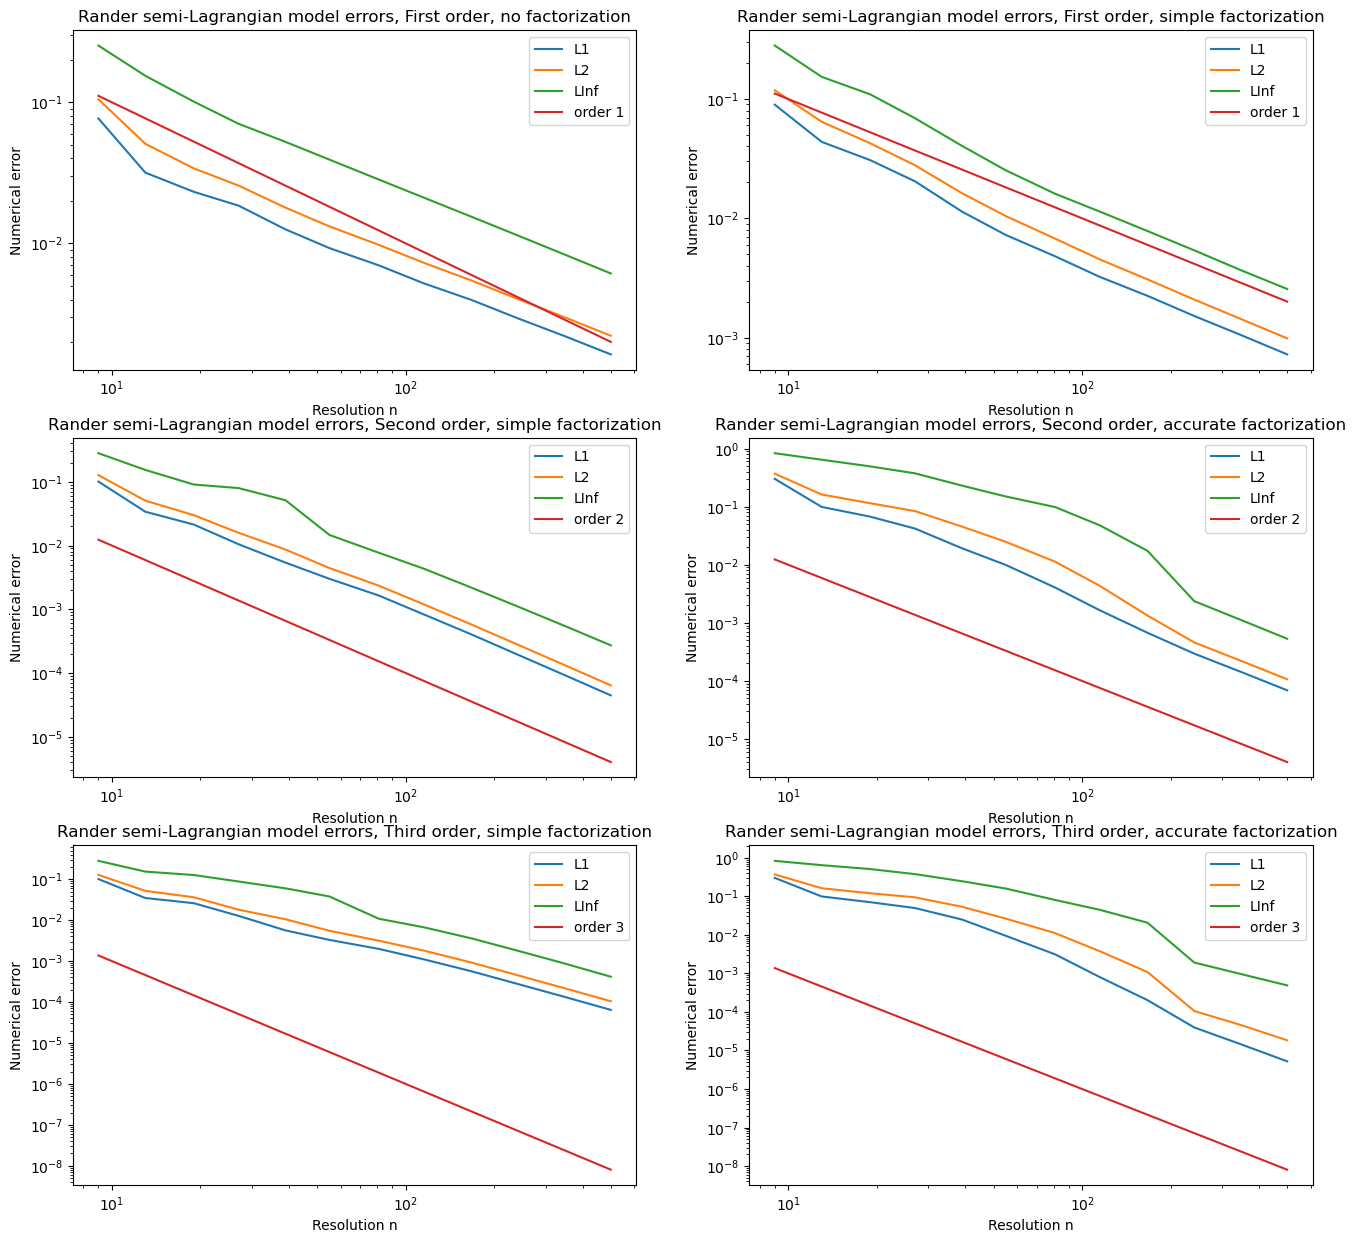

In [31]:
plt.figure(figsize=[16,15])
for i,(scheme,result) in enumerate(zip(schemes,results)):
    plt.subplot(3,2,1+i)
    plt.title("Rander semi-Lagrangian model errors, "+scheme[1])
    plt.loglog(resolutions, result[:,:-1], resolutions, 1/resolutions**scheme[2])
    plt.xlabel("Resolution n"); plt.ylabel("Numerical error")
    plt.legend(("L1","L2","LInf",f"order {scheme[2]}"))

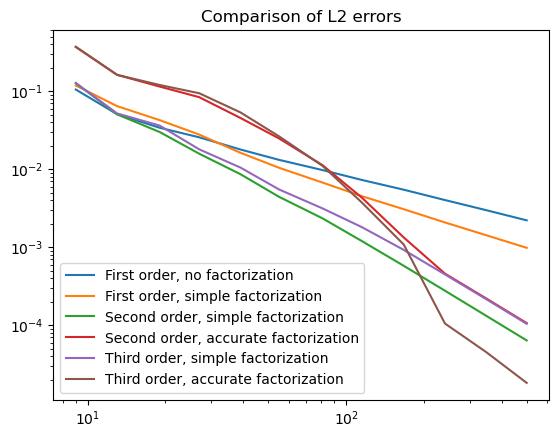

In [32]:
plt.title("Comparison of L2 errors")
plt.loglog(resolutions, results[:,:,1].T)
plt.legend([s[1] for s in schemes]);

## 5. Metrics defined by a Hooke tensor

This test case is rather easy in the sense that the data is smooth and varies little over the domain, similarly to the isotropic test case presented above. The empirical results are consistent with the expectations: 
* Third order is achieved, with third order finite differences, but only with the accurate source factorization.
* Second order is achieved, with second order finite differences, and the accurate source factorization helps improve the results by a constant factor. 

In [33]:
def HookeTest(n,update=tuple()):
    """
    Checks the accuracy of isotropic fast marching on a Poincare model of the hyperpolic plane.
    """
    # Setup the model
    hfmIn = Eikonal.dictIn({
        'model':'Seismic2',
        'seed': [2.,0.],
        'exportValues':1.,
        'verbosity':0,
    })
    hfmIn.SetRect([[1,3],[-1,1]],dimx=n)
    X = hfmIn.Grid()
    hooke = Metrics.Seismic.Hooke.mica[0].extract_xz().rotate_by(0.5)
    hfmIn['metric'] = HighAccuracy.ConformalApply(hooke, HighAccuracy.ConformalMap, X)
    hfmIn.update(update)
    
    # Run, and compute the exact solution
    hfmOut = hfmIn.Run()
    approx = hfmOut['values']
    exact = HighAccuracy.MappedNormValues(hooke,HighAccuracy.ConformalMap,X,hfmIn['seed'])
    shadow = False #norm(X,ord=np.inf,axis=0)>=1.8
#    plt.contourf(*X,approx); plt.axis('equal')
    
    # Output
    result = [norm(np.where(shadow,0,approx-exact),ord=p,averaged=True) for p in (1,2,np.inf)] # L1, L2, LInf errors
    result.append(hfmOut['FMCPUTime'])
    return result

In [34]:
HookeTest(11)

[0.008180538198285934, 0.009871764367935904, 0.022105099515965176, 0.000357]

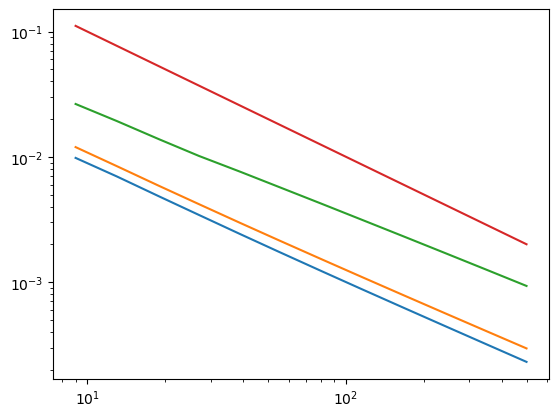

In [35]:
result = np.array([HookeTest(n,update=schemes[0][0]) for n in resolutions])
plt.loglog(resolutions, result[:,:-1],resolutions,1/resolutions);

Be prepared for a few minutes of waiting time. As mentioned in the [HighAccuracy](../Notebooks_FMM/HighAccuracy.ipynb) notebook, the bulk of computation time is related to the preparation of source factorization which implemented in Python rather, and not to the fast marching method which is efficiently implemented in C++.

In [36]:
%%time
results = np.array([[HookeTest(n,update=scheme[0]) for n in resolutions] for scheme in schemes])

CPU times: user 39.9 s, sys: 12.3 s, total: 52.2 s
Wall time: 1min 16s


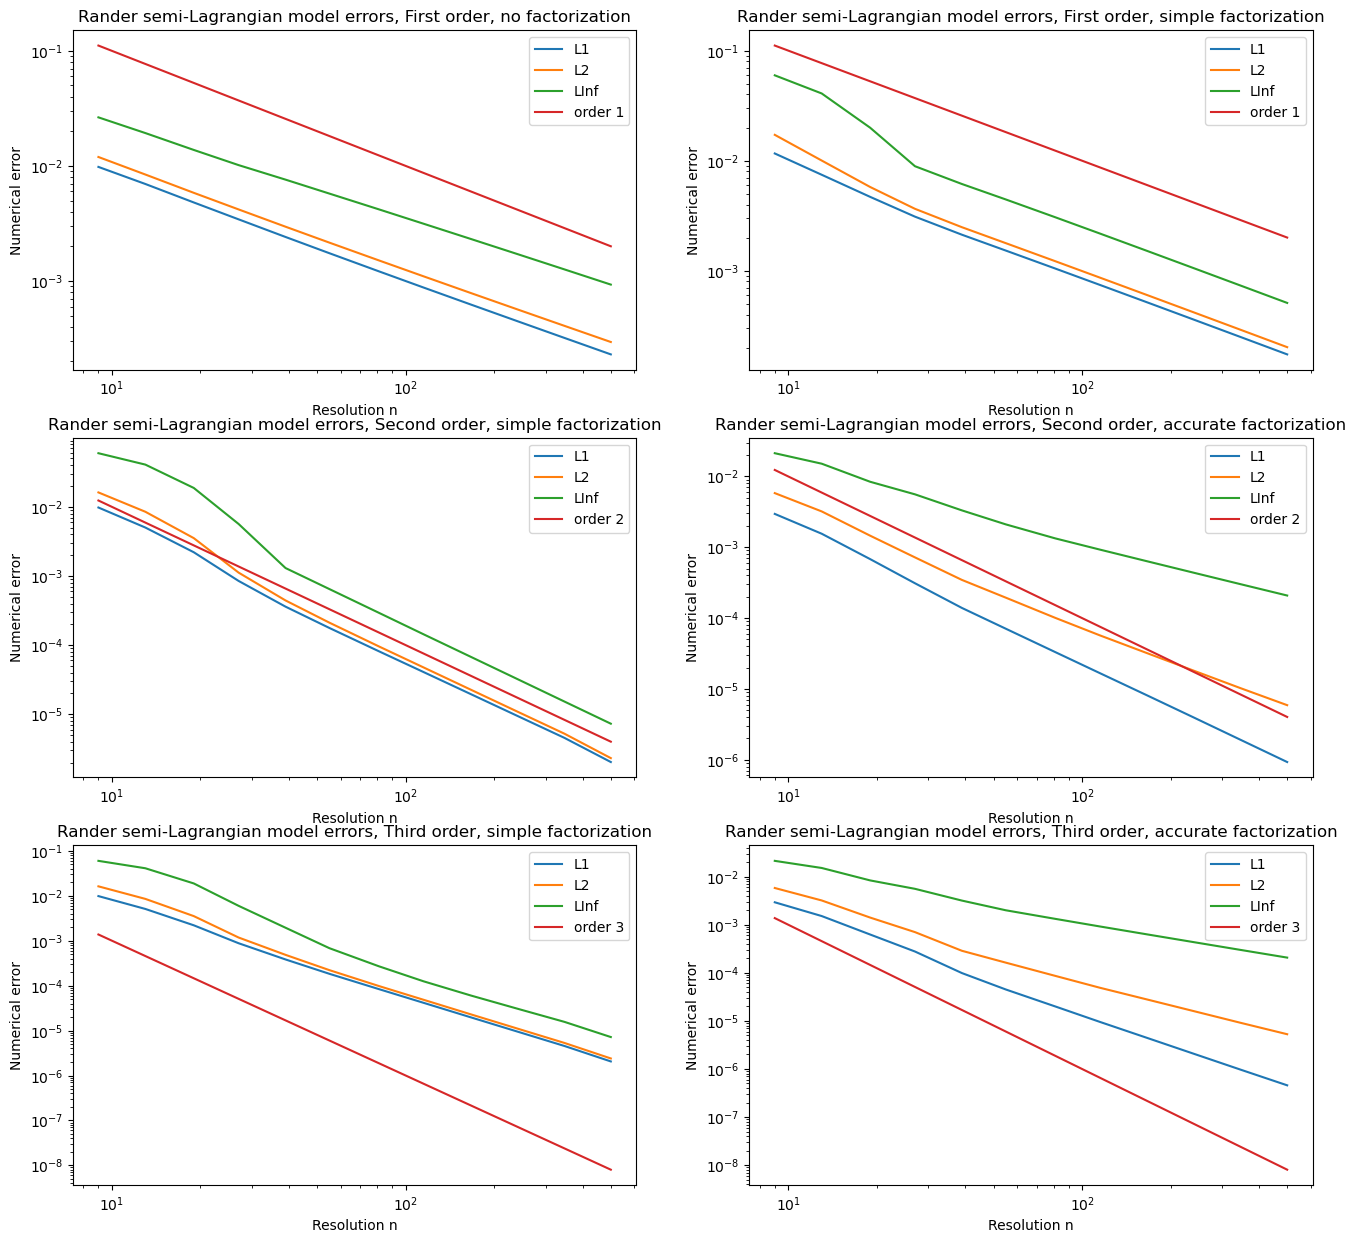

In [37]:
plt.figure(figsize=[16,15])
for i,(scheme,result) in enumerate(zip(schemes,results)):
    plt.subplot(3,2,1+i)
    plt.title("Rander semi-Lagrangian model errors, "+scheme[1])
    plt.loglog(resolutions, result[:,:-1], resolutions, 1/resolutions**scheme[2])
    plt.xlabel("Resolution n"); plt.ylabel("Numerical error")
    plt.legend(("L1","L2","LInf",f"order {scheme[2]}"))

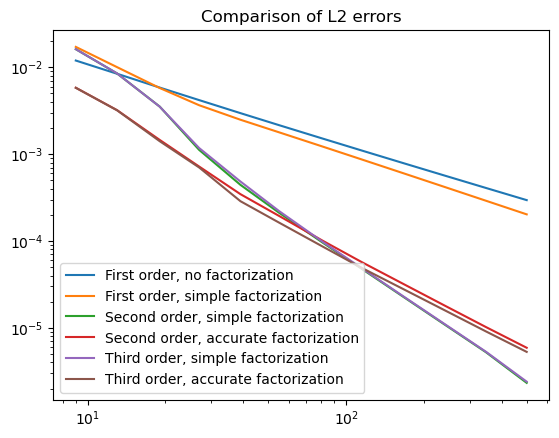

In [38]:
plt.title("Comparison of L2 errors")
plt.loglog(resolutions, results[:,:,1].T)
plt.legend([s[1] for s in schemes]);